# <span style='color:SteelBlue'>P6 - Segmentez des clients d'un site e-commerce</span>

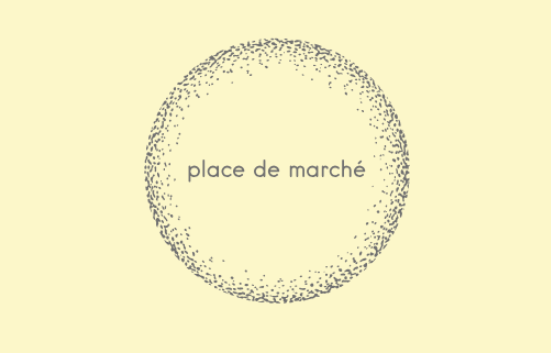

# <span class='bg-primary'>P6_01 - NLP - Données Textuelles - Classification Supervisée</span>

# <span class='bg-primary'>P6_01_03 - Words Embeddings</span>

## <span style='background:Thistle'>Sommaire du notebook</span> 

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

Ce Notebook traite le NLP avec les méthodes classiques avec classification supervisée.

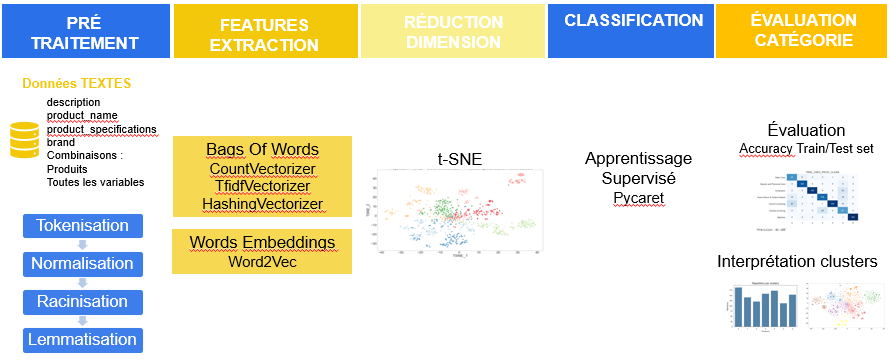

Les meilleurs résultats sont obtenus avec :

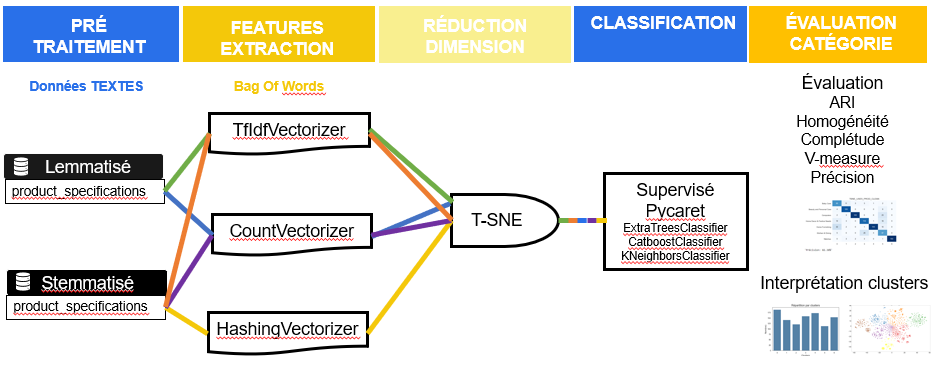

## <span style='background:Thistle'>1. Introduction</span>

**Mission**
*****
Réaliser une première **étude de faisabilité** d'un moteur de **classification d'articles** basé sur une **image et une description** pour l'**automatisation** de l'attribution de la **catégorie de l'article**.

**Objectifs**
*****
- analyser le jeu de données,
- réaliser :
    - un prétraitement des images,
    - un prétraitement des descriptions des produits
    - une réduction de dimension, 
    - puis un clustering. 

La représentation graphique aidera à convaincre que cette approche de modélisation permettra bien de regrouper des produits de même catégorie.

**Contraintes**
***
Afin d’extraire les features, mettre en œuvre a minima un algorithme de type SIFT / ORB / SURF (un algorithme de type CNN Transfer Learning peut éventuellement être utilisé en complément, s’il peut apporter un éclairage supplémentaire à la démonstration).

**Sources**
*****
- [Jeu de données](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip)

In [1]:
# Chargement des librairies
import datetime
import time
import sys
import os
import string
import json
from datetime import datetime
import jyquickhelper
import numpy as np
import pandas as pd
import outils_data
import outils_nlp
import outils_visu
import outils_acp
import outils_segmentation
import matplotlib as mpl
import matplotlib.pyplot as plt
# Feature extraction
import seaborn as sns
import sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, \
    HashingVectorizer
# Traitement de text
import texthero as hero
from texthero import preprocessing
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, FreqDist
from stop_words import get_stop_words
from gensim.models import Word2Vec
import multiprocessing
# Réduction dimension
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report

# Warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
# Chargement à chaud des librairies personnelles
%load_ext autoreload
%autoreload 2
# Valide code pep8
%load_ext pycodestyle_magic
%pycodestyle_on
# %pycodestyle_off

# Versions
print('Version des librairies utilisées :')
print('jyquickhelper         : ' + jyquickhelper.__version__)
print('Python                : ' + sys.version)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Matplotlib            : ' + mpl.__version__)
print('Seaborn               : ' + sns.__version__)
print('Sklearn               : ' + sklearn.__version__)
print('Outils dataframe      : ' + outils_data.__version__)
print('Outils NLP            : ' + outils_nlp.__version__)
print('Outils visualisation  : ' + outils_visu.__version__)
print('Outils ACP            : ' + outils_acp.__version__)
print('Outils SEGMENTATION   : ' + outils_segmentation.__version__)
now = datetime.now().isoformat()
print('Lancé le           : ' + now)

Version des librairies utilisées :
jyquickhelper         : 0.4.220
Python                : 3.8.8 (default, Feb 24 2021, 15:54:32) [MSC v.1928 64 bit (AMD64)]
NumPy                 : 1.19.5
Pandas                : 1.2.2
Matplotlib            : 3.3.4
Seaborn               : 0.11.0
Sklearn               : 0.23.2
Outils dataframe      : 0.0.2
Outils NLP            : 0.0.0
Outils visualisation  : 0.0.2
Outils ACP            : 0.0.1
Outils SEGMENTATION   : 0.0.0
Lancé le           : 2021-06-17T09:16:36.647556


In [2]:
dico_pd_option = {
    'display.max_rows': 400,
    'display.max_column': 200,
    'display.width': 300,
    'display.precision': 5,
    'display.max_colwidth': 1000,
    'mode.chained_assignment': None
}
for cle, val in dico_pd_option.items():
    pd.set_option(cle, val)

## <span style='background:Thistle'>2. Chargement du jeu de données</span>

In [3]:
# Nombre aléatoire pour la reproductibilité des résultats
seed = 21

In [4]:
# Chargement du jeu de données
data = pd.read_csv('data_clean.csv')
# Supprime varaible Unnamed: 0
data.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
data_cat = data['Categorie_1']

In [6]:
# Taille : nombre de lignes/colonnes
nRow, nVar = data.shape
print(f'Le jeu de données contient {nRow} lignes et {nVar} variables.')

Le jeu de données contient 1050 lignes et 23 variables.


In [7]:
# 2 premières lignes
data.head(2)

,product_name,brand,image,product_category_tree,description,product_specifications,Categorie_1,description_clean,description_clean_stem,description_clean_lemma,product_name_clean,product_name_stem,product_name_lemma,product_specifications_clean,product_specifications_stem,product_specifications_lemma,brand_clean,brand_stem,brand_lemma,description_lemma_token,description_stem_token,product_specifications_token,product_specifications_stem_token
0,Elegance Polyester Multicolor Abstract Eyelet Door Curtain,Elegance,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do...,"Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that ...","{""product_specification""=>[{""key""=>""Brand"", ""value""=>""Elegance""}, {""key""=>""Designed For"", ""value""=>""Door""}, {""key""=>""Type"", ""value""=>""Eyelet""}, {""key""=>""Model Name"", ""value""=>""Abstract Polyester Door Curtain Set Of 2""}, {""key""=>""Model ID"", ""value""=>""Duster25""}, {""key""=>""Color"", ""value""=>""Multicolor""}, {""key""=>""Length"", ""value""=>""213 cm""}, {""key""=>""Number of Contents in Sales Package"", ""value""=>""Pack of 2""}, {""key""=>""Sales Package"", ""value""=>""2 Curtains""}, {""key""=>""Material"", ""value""=>""Polyester""}]}",Home Furnishing,key elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain height pack curtain enhances look interiors curtain made high quality polyester fabric eyelet style metal ring makes room environment curtain ant wrinkle anti shrinkage elegant give home bright appeal designs attention sure contemporary eyelet curtains smoothly draw apart first thing morning bright sun rays want wish good morning whole world draw evening create special beauty soothing prints bring home elegant curtain light room get right amount elegance polyester multicolor abstract eyelet door curtain height pack general brand elegance designed door type eyelet model name abstract polyester door curtain set model id color multicolor dimensions length box number contents sales package pack sales package curtains body design material polyester,key eleg polyest multicolor abstract eyelet door curtain floral curtain eleg polyest multicolor abstract eyelet door curtain height pack curtain enhanc look interior curtain made high qualiti polyest fabric eyelet style metal ring make room environ curtain ant wrinkl anti shrinkag eleg give home bright appeal design attent sure contemporari eyelet curtain smoothli draw apart first thing morn bright sun ray want wish good morn whole world draw even creat special beauti sooth print bring home eleg curtain light room get right amount eleg polyest multicolor abstract eyelet door curtain height pack gener brand eleg design door type eyelet model name abstract polyest door curtain set model id color multicolor dimens length box number content sale packag pack sale packag curtain bodi design materi polyest,key elegance polyester multic

In [66]:
# Dataframe de sauvegarde des résultats des scores
# df_accuracy_class_we = pd.DataFrame()
# Chargement des données de sauvegarde des résultats des métriques KMeans
df_accuracy_class_we = pd.read_csv('data_accuracy_classification_we.csv')
# Supprime variable Unnamed: 0
df_accuracy_class_we.drop('Unnamed: 0', axis=1, inplace=True)

## <span style='background:Thistle'>4. Feature extraction - Words embeddings</span>

### <span style='background:PowderBlue'>4.1. BOW - Bags of words - CountVectorizer</span>

**description** - lemmatisée

In [13]:
# Variable dont on veut extraire les features
data['description_clean_lemma'] = \
    data['description_clean_lemma'].fillna('').astype(str)
desc_lem_data = data['description_clean_lemma']

In [14]:
# Instanciation
countvectorizer_desc_lem = CountVectorizer()
# Tokenisation et création du vocabulaire
countvectorizer_desc_lem.fit(desc_lem_data)
# Résumé du vocabulaire
# print(desc_lem_vectorizer.get_feature_names()[0:10])
# print(desc_lem_vectorizer.vocabulary_)
# Encodage/Vectorisation
vector_countvectorizer_desc_lem = \
    countvectorizer_desc_lem.transform(desc_lem_data)

In [67]:
titre = 'TSNE_CV_DESC_LEM'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8419,0.9567,0.8427,0.8545,0.8392,0.8154,0.8180,0.0330
catboost,CatBoost Classifier,0.8296,0.9603,0.8311,0.8402,0.8276,0.8011,0.8035,1.7820
rf,Random Forest Classifier,0.8187,0.9533,0.8195,0.8328,0.8164,0.7884,0.7914,0.0360
xgboost,Extreme Gradient Boosting,0.8105,0.9581,0.8111,0.8193,0.8079,0.7787,0.7809,0.3920
knn,K Neighbors Classifier,0.8024,0.9495,0.8011,0.8150,0.8002,0.7691,0.7719,0.1710
lightgbm,Light Gradient Boosting Machine,0.8011,0.9590,0.8013,0.8100,0.7995,0.7677,0.7695,0.2000
gbc,Gradient Boosting Classifier,0.7942,0.9546,0.7932,0.8062,0.7917,0.7596,0.7623,0.0900
dt,Decision Tree Classifier,0.7914,0.8783,0.7905,0.8037,0.7887,0.7563,0.7591,0.0050
qda,Quadratic Discriminant Analysis,0.5694,0.8457,0.5726,0.5730,0.5439,0.4988,0.5107,0.0050
lda,Linear Discriminant Analysis,0.5285,0.8450,0.5202,0.5313,0.5064,0.4476,0.4535,0.0050


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8956,0.9861,0.8890,0.8959,0.8951,0.8774,0.8776


Clusters,Nombre,%
Baby Care,35,11.08000
Beauty and Personal Care,39,12.34000
Computers,42,13.29000
Home Decor & Festive Needs,40,12.66000
Home Furnishing,65,20.57000
Kitchen & Dining,50,15.82000
Watches,45,14.24000


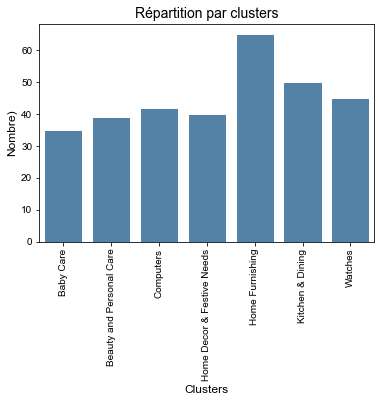

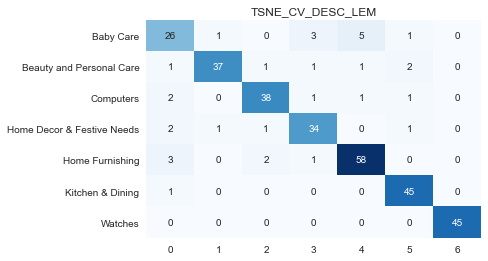

'Précision: 89.56%'

                            precision    recall  f1-score   support

                 Baby Care       0.74      0.72      0.73        36
  Beauty and Personal Care       0.95      0.86      0.90        43
                 Computers       0.90      0.88      0.89        43
Home Decor & Festive Needs       0.85      0.87      0.86        39
           Home Furnishing       0.89      0.91      0.90        64
          Kitchen & Dining       0.90      0.98      0.94        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.90       316
                 macro avg       0.89      0.89      0.89       316
              weighted avg       0.90      0.90      0.90       316


In [16]:
outils_nlp.classifier_pycaret(data_cat, vector_countvectorizer_desc_lem,
                              titre)

In [68]:
# Sauvegarde des résultats
df_accuracy_class_we = \
    outils_nlp.sauvegarder_accuracy_we_pycaret(df_accuracy_class_we,
                                               '0.8419', '0.8956', titre)
df_accuracy_class_we[df_accuracy_class_we['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
0,TSNE_CV_DESC_LEM,0.8419,0.8956


**description** - stemmatisée

In [18]:
# Variable dont on veut extraire les features
data['description_clean_stem'] = \
    data['description_clean_stem'].fillna('').astype(str)
desc_stem_data = data['description_clean_stem']

In [19]:
# Instanciation
countvectorizer_desc_stem = CountVectorizer()
# Tokenisation et création du vocabulaire
countvectorizer_desc_stem.fit(desc_stem_data)
# Encodage/Vectorisation
vector_countvectorizer_desc_stem = \
    countvectorizer_desc_stem.transform(desc_stem_data)

In [69]:
titre = 'TSNE_CV_DESC_STEM'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8556,0.9605,0.8570,0.8673,0.8541,0.8314,0.8337,0.0370
catboost,CatBoost Classifier,0.8407,0.9681,0.8416,0.8487,0.8386,0.8140,0.8159,1.7870
rf,Random Forest Classifier,0.8366,0.9579,0.8376,0.8461,0.8345,0.8092,0.8113,0.0410
xgboost,Extreme Gradient Boosting,0.8175,0.9651,0.8186,0.8267,0.8150,0.7869,0.7889,0.5870
lightgbm,Light Gradient Boosting Machine,0.8161,0.9642,0.8170,0.8269,0.8142,0.7852,0.7874,0.2340
knn,K Neighbors Classifier,0.8134,0.9484,0.8113,0.8249,0.8110,0.7819,0.7845,0.0080
gbc,Gradient Boosting Classifier,0.8038,0.9594,0.8024,0.8171,0.8015,0.7708,0.7736,0.1080
dt,Decision Tree Classifier,0.8024,0.8848,0.8009,0.8141,0.8020,0.7692,0.7713,0.0060
qda,Quadratic Discriminant Analysis,0.6661,0.8937,0.6675,0.7036,0.6650,0.6101,0.6165,0.0050
nb,Naive Bayes,0.6621,0.8821,0.6643,0.7231,0.6590,0.6056,0.6154,0.0050


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9177,0.9914,0.9126,0.9194,0.9177,0.9033,0.9036


Clusters,Nombre,%
Baby Care,35,11.08000
Beauty and Personal Care,43,13.61000
Computers,44,13.92000
Home Decor & Festive Needs,34,10.76000
Home Furnishing,69,21.84000
Kitchen & Dining,47,14.87000
Watches,44,13.92000


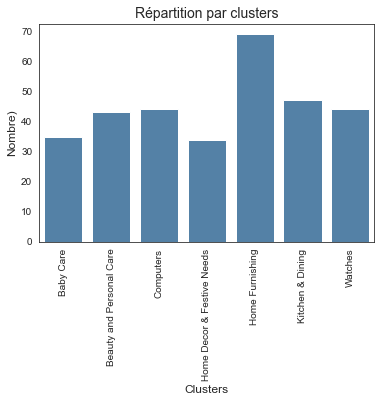

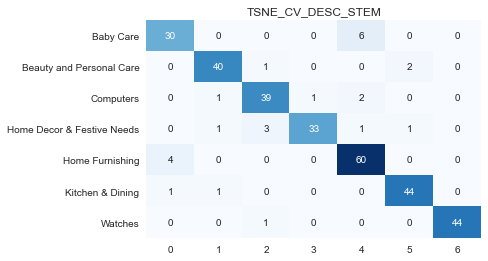

'Précision: 91.77%'

                            precision    recall  f1-score   support

                 Baby Care       0.86      0.83      0.85        36
  Beauty and Personal Care       0.93      0.93      0.93        43
                 Computers       0.89      0.91      0.90        43
Home Decor & Festive Needs       0.97      0.85      0.90        39
           Home Furnishing       0.87      0.94      0.90        64
          Kitchen & Dining       0.94      0.96      0.95        46
                   Watches       1.00      0.98      0.99        45

                  accuracy                           0.92       316
                 macro avg       0.92      0.91      0.92       316
              weighted avg       0.92      0.92      0.92       316


In [21]:
outils_nlp.classifier_pycaret(data_cat, vector_countvectorizer_desc_stem,
                              titre)

In [70]:
# Sauvegarde des résultats
df_accuracy_class_we = \
    outils_nlp.sauvegarder_accuracy_we_pycaret(df_accuracy_class_we,
                                               '0.8556', '0.9177', titre)
df_accuracy_class_we[df_accuracy_class_we['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
1,TSNE_CV_DESC_STEM,0.8556,0.9177


**produit_specification** - lemmatisée

In [23]:
# Variable dont on veut extraire les features
data['product_specifications_lemma'] = \
    data['product_specifications_lemma'].fillna('').astype(str)
prod_lem_data = data['product_specifications_lemma']

In [24]:
# Instanciation
countvectorizer_prod_lem = CountVectorizer()
# Tokenisation et création du vocabulaire
countvectorizer_prod_lem.fit(prod_lem_data)
# Encodage/Vectorisation
vector_countvectorizer_prod_lem = \
    countvectorizer_prod_lem.transform(prod_lem_data)

In [71]:
titre = 'TSNE_CV_PROD_LEM'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9128,0.9783,0.9129,0.9192,0.9121,0.8981,0.8994,0.0330
rf,Random Forest Classifier,0.8896,0.9804,0.8910,0.8975,0.8885,0.8711,0.8728,0.0370
catboost,CatBoost Classifier,0.8896,0.9848,0.8910,0.8992,0.8883,0.8710,0.8728,1.7540
xgboost,Extreme Gradient Boosting,0.8788,0.9807,0.8789,0.8877,0.8776,0.8584,0.8599,0.2810
lightgbm,Light Gradient Boosting Machine,0.8773,0.9832,0.8775,0.8900,0.8783,0.8567,0.8584,0.2120
gbc,Gradient Boosting Classifier,0.8760,0.9794,0.8761,0.8860,0.8740,0.8552,0.8571,0.0900
dt,Decision Tree Classifier,0.8665,0.9219,0.8682,0.8751,0.8657,0.8440,0.8457,0.0050
knn,K Neighbors Classifier,0.8610,0.9715,0.8629,0.8709,0.8596,0.8377,0.8397,0.0070
qda,Quadratic Discriminant Analysis,0.7888,0.9586,0.7848,0.8094,0.7859,0.7530,0.7571,0.0050
nb,Naive Bayes,0.7547,0.9527,0.7463,0.7778,0.7499,0.7130,0.7182,0.0050


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9430,0.9907,0.9386,0.9448,0.9429,0.9331,0.9335


Clusters,Nombre,%
Baby Care,34,10.76000
Beauty and Personal Care,43,13.61000
Computers,38,12.03000
Home Decor & Festive Needs,44,13.92000
Home Furnishing,65,20.57000
Kitchen & Dining,47,14.87000
Watches,45,14.24000


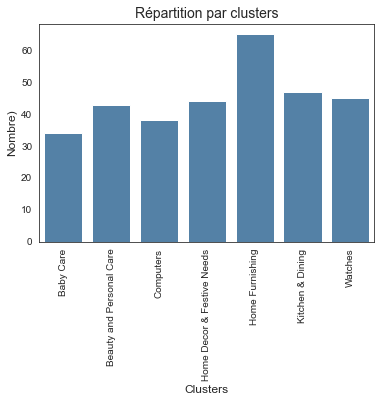

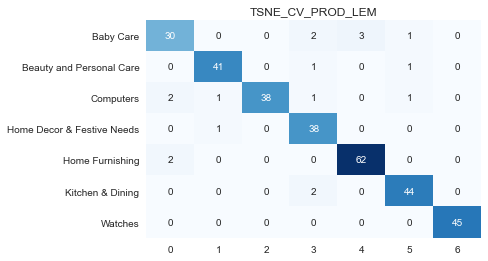

'Précision: 94.3%'

                            precision    recall  f1-score   support

                 Baby Care       0.88      0.83      0.86        36
  Beauty and Personal Care       0.95      0.95      0.95        43
                 Computers       1.00      0.88      0.94        43
Home Decor & Festive Needs       0.86      0.97      0.92        39
           Home Furnishing       0.95      0.97      0.96        64
          Kitchen & Dining       0.94      0.96      0.95        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.94       316
                 macro avg       0.94      0.94      0.94       316
              weighted avg       0.94      0.94      0.94       316


In [26]:
outils_nlp.classifier_pycaret(data_cat, vector_countvectorizer_prod_lem,
                              titre)

In [72]:
# Sauvegarde des résultats
df_accuracy_class_we = \
    outils_nlp.sauvegarder_accuracy_we_pycaret(df_accuracy_class_we,
                                               '0.9128', '0.9430', titre)
df_accuracy_class_we[df_accuracy_class_we['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
2,TSNE_CV_PROD_LEM,0.9128,0.9430


**produit_specification** - stemmatisée

In [28]:
# Variable dont on veut extraire les features
data['product_specifications_stem'] = \
    data['product_specifications_stem'].fillna('').astype(str)
prod_stem_data = data['product_specifications_stem']

In [30]:
# Instanciation
countvectorizer_prod_stem = CountVectorizer()
# Tokenisation et création du vocabulaire
countvectorizer_prod_stem.fit(prod_stem_data)
# Encodage/Vectorisation
vector_countvectorizer_prod_stem = \
    countvectorizer_prod_stem.transform(prod_stem_data)

In [73]:
titre = 'TSNE_CV_PROD_STEM'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9196,0.9830,0.9204,0.9240,0.9189,0.9061,0.9071,0.0320
catboost,CatBoost Classifier,0.9073,0.9892,0.9085,0.9129,0.9065,0.8917,0.8928,1.6690
xgboost,Extreme Gradient Boosting,0.9046,0.9865,0.9070,0.9099,0.9035,0.8885,0.8897,0.2720
rf,Random Forest Classifier,0.9032,0.9843,0.9039,0.9080,0.9022,0.8869,0.8881,0.0370
lightgbm,Light Gradient Boosting Machine,0.9005,0.9886,0.9017,0.9063,0.8988,0.8838,0.8852,0.2020
knn,K Neighbors Classifier,0.8815,0.9787,0.8828,0.8865,0.8802,0.8616,0.8628,0.0080
dt,Decision Tree Classifier,0.8814,0.9307,0.8823,0.8867,0.8793,0.8615,0.8630,0.0060
gbc,Gradient Boosting Classifier,0.8678,0.9826,0.8679,0.8768,0.8670,0.8455,0.8470,0.0910
nb,Naive Bayes,0.8188,0.9526,0.8185,0.8395,0.8205,0.7882,0.7914,0.0050
qda,Quadratic Discriminant Analysis,0.8120,0.9688,0.8118,0.8331,0.8130,0.7802,0.7837,0.0050


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9335,0.9911,0.9304,0.9364,0.9341,0.9220,0.9223


Clusters,Nombre,%
Baby Care,38,12.03000
Beauty and Personal Care,41,12.97000
Computers,38,12.03000
Home Decor & Festive Needs,40,12.66000
Home Furnishing,64,20.25000
Kitchen & Dining,50,15.82000
Watches,45,14.24000


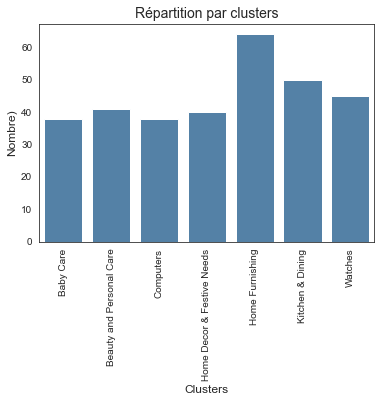

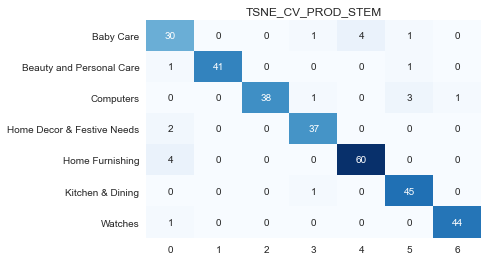

'Précision: 93.35%'

                            precision    recall  f1-score   support

                 Baby Care       0.79      0.83      0.81        36
  Beauty and Personal Care       1.00      0.95      0.98        43
                 Computers       1.00      0.88      0.94        43
Home Decor & Festive Needs       0.93      0.95      0.94        39
           Home Furnishing       0.94      0.94      0.94        64
          Kitchen & Dining       0.90      0.98      0.94        46
                   Watches       0.98      0.98      0.98        45

                  accuracy                           0.93       316
                 macro avg       0.93      0.93      0.93       316
              weighted avg       0.94      0.93      0.93       316


1:80: E501 line too long (80 > 79 characters)


In [33]:
outils_nlp.classifier_pycaret(data_cat, vector_countvectorizer_prod_stem,
                              titre)

In [74]:
# Sauvegarde des résultats
df_accuracy_class_we = \
    outils_nlp.sauvegarder_accuracy_we_pycaret(df_accuracy_class_we,
                                               '0.9196', '0.9335', titre)
df_accuracy_class_we[df_accuracy_class_we['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
3,TSNE_CV_PROD_STEM,0.9196,0.9335


### <span style='background:PowderBlue'>4.2. BOW - TfidfVectorizer</span>

**description** - lemmatisée

In [35]:
# Instanciation
tfidfvectorizer_desc_lem = TfidfVectorizer()
# Tokenisation et création du vocabulaire
tfidfvectorizer_desc_lem.fit(desc_lem_data)
# Encodage/Vectorisation
vector_tfidfvectorizer_desc_lem = \
    tfidfvectorizer_desc_lem.transform(desc_lem_data)

In [75]:
titre = 'TSNE_TFIDF_DESC_LEM'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8909,0.9815,0.8931,0.8963,0.8890,0.8725,0.8740,1.7000
et,Extra Trees Classifier,0.8896,0.9768,0.8908,0.8994,0.8885,0.8710,0.8729,0.0320
rf,Random Forest Classifier,0.8759,0.9773,0.8783,0.8822,0.8749,0.8551,0.8564,0.0350
knn,K Neighbors Classifier,0.8637,0.9700,0.8661,0.8718,0.8635,0.8408,0.8421,0.0060
xgboost,Extreme Gradient Boosting,0.8636,0.9751,0.8647,0.8695,0.8630,0.8407,0.8419,0.3120
lightgbm,Light Gradient Boosting Machine,0.8596,0.9769,0.8604,0.8660,0.8590,0.8360,0.8372,0.2200
dt,Decision Tree Classifier,0.8528,0.9139,0.8533,0.8610,0.8515,0.8281,0.8298,0.0050
gbc,Gradient Boosting Classifier,0.8405,0.9724,0.8418,0.8510,0.8401,0.8137,0.8157,0.0890
nb,Naive Bayes,0.7165,0.8943,0.7192,0.7287,0.7116,0.6686,0.6724,0.0060
qda,Quadratic Discriminant Analysis,0.7165,0.9065,0.7194,0.7393,0.7145,0.6687,0.6731,0.0050


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.9114,0.9900,0.9046,0.9110,0.9108,0.8960,0.8961


Clusters,Nombre,%
Baby Care,33,10.44000
Beauty and Personal Care,41,12.97000
Computers,43,13.61000
Home Decor & Festive Needs,40,12.66000
Home Furnishing,66,20.89000
Kitchen & Dining,48,15.19000
Watches,45,14.24000


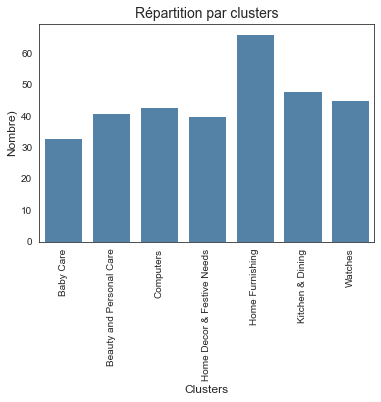

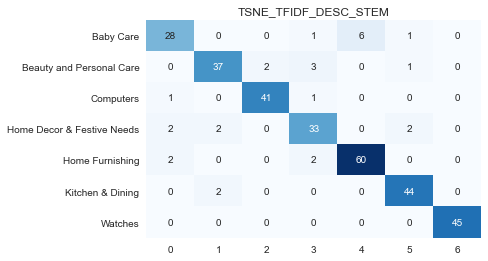

'Précision: 91.14%'

                            precision    recall  f1-score   support

                 Baby Care       0.85      0.78      0.81        36
  Beauty and Personal Care       0.90      0.86      0.88        43
                 Computers       0.95      0.95      0.95        43
Home Decor & Festive Needs       0.82      0.85      0.84        39
           Home Furnishing       0.91      0.94      0.92        64
          Kitchen & Dining       0.92      0.96      0.94        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.91       316
                 macro avg       0.91      0.90      0.91       316
              weighted avg       0.91      0.91      0.91       316


In [37]:
outils_nlp.classifier_pycaret(data_cat, vector_tfidfvectorizer_desc_lem,
                              titre)

In [76]:
# Sauvegarde des résultats
df_accuracy_class_we = \
    outils_nlp.sauvegarder_accuracy_we_pycaret(df_accuracy_class_we,
                                               '0.8909', '0.9114', titre)
df_accuracy_class_we[df_accuracy_class_we['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
4,TSNE_TFIDF_DESC_LEM,0.8909,0.9114


**description** - stemmatisée

In [39]:
# Instanciation
tfidfvectorizer_desc_stem = TfidfVectorizer()
# Tokenisation et création du vocabulaire
tfidfvectorizer_desc_stem.fit(desc_stem_data)
# Encodage/Vectorisation
vector_tfidfvectorizer_desc_stem = \
    tfidfvectorizer_desc_stem.transform(desc_stem_data)

In [77]:
titre = 'TSNE_TFIDF_DESC_STEM'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.8923,0.9835,0.8936,0.9009,0.8920,0.8742,0.8757,0.0420
et,Extra Trees Classifier,0.8909,0.9821,0.8924,0.9006,0.8903,0.8726,0.8745,0.0390
catboost,CatBoost Classifier,0.8882,0.9819,0.8898,0.8970,0.8880,0.8694,0.8709,1.6990
xgboost,Extreme Gradient Boosting,0.8814,0.9787,0.8816,0.8901,0.8815,0.8614,0.8629,0.3670
lightgbm,Light Gradient Boosting Machine,0.8801,0.9777,0.8812,0.8909,0.8793,0.8598,0.8618,0.2190
knn,K Neighbors Classifier,0.8760,0.9732,0.8766,0.8835,0.8739,0.8551,0.8570,0.0070
gbc,Gradient Boosting Classifier,0.8719,0.9771,0.8742,0.8814,0.8710,0.8503,0.8522,0.0930
dt,Decision Tree Classifier,0.8583,0.9179,0.8581,0.8690,0.8585,0.8344,0.8360,0.0050
qda,Quadratic Discriminant Analysis,0.7165,0.9230,0.7227,0.7236,0.7093,0.6690,0.6725,0.0050
nb,Naive Bayes,0.7083,0.9236,0.7135,0.7140,0.7025,0.6593,0.6623,0.0050


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9177,0.9915,0.9125,0.9177,0.9174,0.9034,0.9035


Clusters,Nombre,%
Baby Care,35,11.08000
Beauty and Personal Care,42,13.29000
Computers,43,13.61000
Home Decor & Festive Needs,37,11.71000
Home Furnishing,65,20.57000
Kitchen & Dining,49,15.51000
Watches,45,14.24000


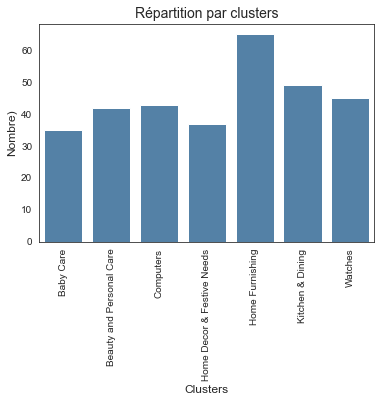

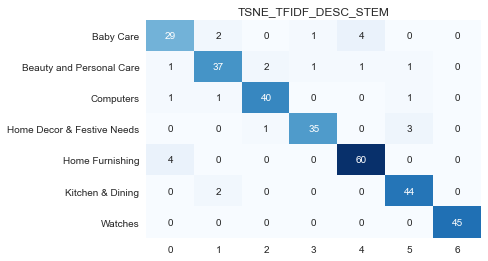

'Précision: 91.77%'

                            precision    recall  f1-score   support

                 Baby Care       0.83      0.81      0.82        36
  Beauty and Personal Care       0.88      0.86      0.87        43
                 Computers       0.93      0.93      0.93        43
Home Decor & Festive Needs       0.95      0.90      0.92        39
           Home Furnishing       0.92      0.94      0.93        64
          Kitchen & Dining       0.90      0.96      0.93        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.92       316
                 macro avg       0.92      0.91      0.91       316
              weighted avg       0.92      0.92      0.92       316


In [41]:
outils_nlp.classifier_pycaret(data_cat, vector_tfidfvectorizer_desc_stem,
                              titre)

In [78]:
# Sauvegarde des résultats
df_accuracy_class_we = \
    outils_nlp.sauvegarder_accuracy_we_pycaret(df_accuracy_class_we,
                                               '0.8923', '0.9177', titre)
df_accuracy_class_we[df_accuracy_class_we['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
5,TSNE_TFIDF_DESC_STEM,0.8923,0.9177


**produit_specification** - lemmatisée

In [43]:
# Instanciation
tfidfvectorizer_prod_lem = TfidfVectorizer()
# Tokenisation et création du vocabulaire
tfidfvectorizer_prod_lem.fit(prod_lem_data)
# Encodage/Vectorisation
vector_tfidfvectorizer_prod_lem = \
    tfidfvectorizer_prod_lem.transform(prod_lem_data)

In [79]:
titre = 'TSNE_TFIDF_PROD_LEM'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9183,0.9836,0.9190,0.9271,0.9170,0.9046,0.9063,0.0310
rf,Random Forest Classifier,0.9060,0.9847,0.9067,0.9105,0.9039,0.8903,0.8917,0.0340
catboost,CatBoost Classifier,0.9046,0.9886,0.9056,0.9127,0.9030,0.8886,0.8904,1.7580
dt,Decision Tree Classifier,0.8992,0.9411,0.8984,0.9075,0.8982,0.8822,0.8838,0.0050
xgboost,Extreme Gradient Boosting,0.8910,0.9853,0.8920,0.8976,0.8886,0.8728,0.8745,0.2360
lightgbm,Light Gradient Boosting Machine,0.8896,0.9858,0.8894,0.8950,0.8883,0.8710,0.8724,0.2100
knn,K Neighbors Classifier,0.8869,0.9752,0.8888,0.8951,0.8843,0.8680,0.8700,0.0080
gbc,Gradient Boosting Classifier,0.8705,0.9830,0.8703,0.8826,0.8697,0.8488,0.8509,0.0860
qda,Quadratic Discriminant Analysis,0.8243,0.9616,0.8257,0.8386,0.8233,0.7948,0.7974,0.0040
nb,Naive Bayes,0.8051,0.9537,0.8029,0.8196,0.8030,0.7722,0.7753,0.0050


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9430,0.9883,0.9351,0.9447,0.9424,0.9330,0.9336


Clusters,Nombre,%
Baby Care,31,9.81000
Beauty and Personal Care,40,12.66000
Computers,40,12.66000
Home Decor & Festive Needs,40,12.66000
Home Furnishing,70,22.15000
Kitchen & Dining,50,15.82000
Watches,45,14.24000


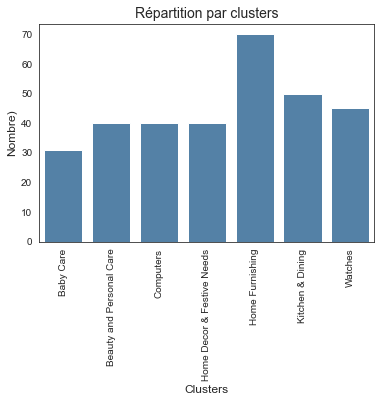

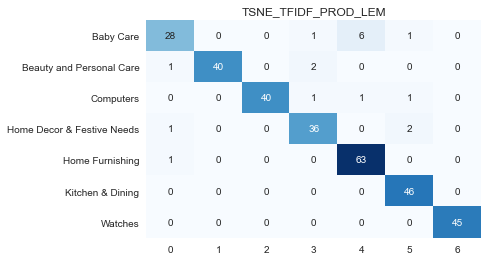

'Précision: 94.3%'

                            precision    recall  f1-score   support

                 Baby Care       0.90      0.78      0.84        36
  Beauty and Personal Care       1.00      0.93      0.96        43
                 Computers       1.00      0.93      0.96        43
Home Decor & Festive Needs       0.90      0.92      0.91        39
           Home Furnishing       0.90      0.98      0.94        64
          Kitchen & Dining       0.92      1.00      0.96        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.94       316
                 macro avg       0.95      0.94      0.94       316
              weighted avg       0.94      0.94      0.94       316


In [45]:
outils_nlp.classifier_pycaret(data_cat, vector_tfidfvectorizer_prod_lem,
                              titre)

In [80]:
# Sauvegarde des résultats
df_accuracy_class_we = \
    outils_nlp.sauvegarder_accuracy_we_pycaret(df_accuracy_class_we,
                                               '0.9183', '0.9430', titre)
df_accuracy_class_we[df_accuracy_class_we['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
6,TSNE_TFIDF_PROD_LEM,0.9183,0.9430


**produit_specification** - stemmatisée

In [81]:
# Instanciation
tfidfvectorizer_prod_stem = TfidfVectorizer()
# Tokenisation et création du vocabulaire
tfidfvectorizer_prod_stem.fit(prod_stem_data)
# Encodage/Vectorisation
vector_tfidfvectorizer_prod_stem = \
    tfidfvectorizer_prod_stem.transform(prod_stem_data)

In [82]:
titre = 'TSNE_TFIDF_PROD_STEM'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9264,0.9906,0.9287,0.9332,0.9252,0.9141,0.9156,1.6500
et,Extra Trees Classifier,0.9209,0.9845,0.9210,0.9303,0.9196,0.9076,0.9095,0.0310
dt,Decision Tree Classifier,0.9196,0.9530,0.9201,0.9246,0.9194,0.9061,0.9070,0.0050
rf,Random Forest Classifier,0.9196,0.9879,0.9203,0.9267,0.9190,0.9061,0.9074,0.0340
lightgbm,Light Gradient Boosting Machine,0.9032,0.9857,0.9025,0.9119,0.9018,0.8869,0.8888,0.1750
xgboost,Extreme Gradient Boosting,0.9004,0.9855,0.8999,0.9087,0.8991,0.8837,0.8855,0.2770
gbc,Gradient Boosting Classifier,0.8991,0.9837,0.8995,0.9093,0.8979,0.8822,0.8840,0.0920
knn,K Neighbors Classifier,0.8978,0.9818,0.9005,0.9059,0.8961,0.8807,0.8826,0.1770
qda,Quadratic Discriminant Analysis,0.8297,0.9687,0.8330,0.8483,0.8282,0.8011,0.8043,0.0060
nb,Naive Bayes,0.8254,0.9634,0.8256,0.8413,0.8244,0.7961,0.7989,0.0050


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.9272,0.9935,0.9224,0.9304,0.9278,0.9146,0.9149


Clusters,Nombre,%
Baby Care,40,12.66000
Beauty and Personal Care,41,12.97000
Computers,41,12.97000
Home Decor & Festive Needs,35,11.08000
Home Furnishing,64,20.25000
Kitchen & Dining,50,15.82000
Watches,45,14.24000


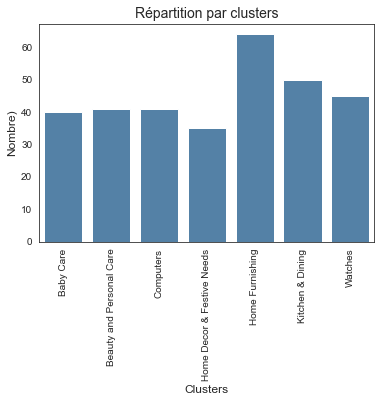

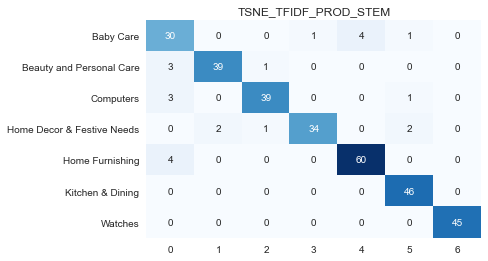

'Précision: 92.72%'

                            precision    recall  f1-score   support

                 Baby Care       0.75      0.83      0.79        36
  Beauty and Personal Care       0.95      0.91      0.93        43
                 Computers       0.95      0.91      0.93        43
Home Decor & Festive Needs       0.97      0.87      0.92        39
           Home Furnishing       0.94      0.94      0.94        64
          Kitchen & Dining       0.92      1.00      0.96        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.93       316
                 macro avg       0.93      0.92      0.92       316
              weighted avg       0.93      0.93      0.93       316


In [83]:
outils_nlp.classifier_pycaret(data_cat, vector_tfidfvectorizer_prod_stem,
                              titre)

In [84]:
# Sauvegarde des résultats
df_accuracy_class_we = \
    outils_nlp.sauvegarder_accuracy_we_pycaret(df_accuracy_class_we,
                                               '0.9264', '0.9272', titre)
df_accuracy_class_we[df_accuracy_class_we['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
7,TSNE_TFIDF_PROD_STEM,0.9264,0.9272


### <span style='background:PowderBlue'>4.3. BOW - Hashing Vectorizer</span>

**description** - lemmatisée

In [85]:
# Instanciation
hashvectorizer_desc_lem = HashingVectorizer(norm=None, n_features=2204)
# Hash/Vectorisation
vector_hashvectorizer_desc_lem = \
    hashvectorizer_desc_lem.fit_transform(desc_lem_data)

In [86]:
titre = 'TSNE_HASH_DESC_LEM'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8666,0.9707,0.8664,0.8760,0.8664,0.8442,0.8458,1.6170
et,Extra Trees Classifier,0.8652,0.9689,0.8665,0.8768,0.8648,0.8427,0.8447,0.0360
rf,Random Forest Classifier,0.8597,0.9655,0.8606,0.8706,0.8595,0.8362,0.8381,0.0350
lightgbm,Light Gradient Boosting Machine,0.8462,0.9697,0.8453,0.8541,0.8442,0.8204,0.8223,0.2040
xgboost,Extreme Gradient Boosting,0.8339,0.9669,0.8332,0.8425,0.8331,0.8061,0.8078,0.3630
knn,K Neighbors Classifier,0.8338,0.9575,0.8322,0.8507,0.8346,0.8059,0.8085,0.0090
gbc,Gradient Boosting Classifier,0.8053,0.9594,0.8051,0.8145,0.8027,0.7728,0.7752,0.0900
dt,Decision Tree Classifier,0.8040,0.8857,0.8018,0.8181,0.8020,0.7711,0.7737,0.0050
qda,Quadratic Discriminant Analysis,0.5655,0.8634,0.5661,0.5812,0.5592,0.4937,0.4989,0.0050
lda,Linear Discriminant Analysis,0.5355,0.8273,0.5197,0.4814,0.4966,0.4550,0.4636,0.0060


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.8671,0.9693,0.8633,0.8680,0.8658,0.8441,0.8447


Clusters,Nombre,%
Baby Care,36,11.39000
Beauty and Personal Care,37,11.71000
Computers,51,16.14000
Home Decor & Festive Needs,37,11.71000
Home Furnishing,61,19.30000
Kitchen & Dining,48,15.19000
Watches,46,14.56000


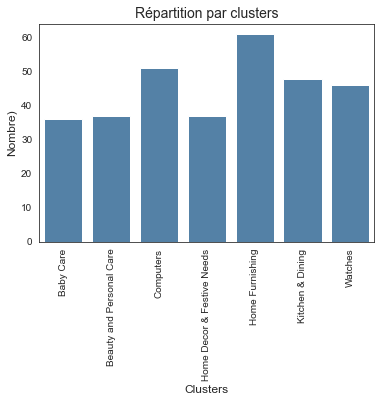

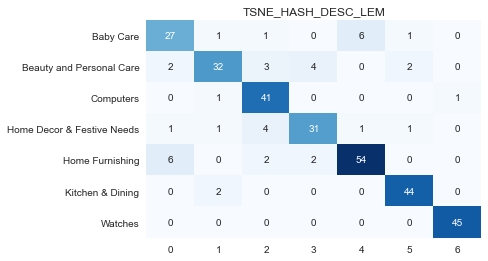

'Précision: 86.71%'

                            precision    recall  f1-score   support

                 Baby Care       0.75      0.75      0.75        36
  Beauty and Personal Care       0.86      0.74      0.80        43
                 Computers       0.80      0.95      0.87        43
Home Decor & Festive Needs       0.84      0.79      0.82        39
           Home Furnishing       0.89      0.84      0.86        64
          Kitchen & Dining       0.92      0.96      0.94        46
                   Watches       0.98      1.00      0.99        45

                  accuracy                           0.87       316
                 macro avg       0.86      0.86      0.86       316
              weighted avg       0.87      0.87      0.87       316


In [87]:
outils_nlp.classifier_pycaret(data_cat, vector_hashvectorizer_desc_lem,
                              titre)

In [88]:
# Sauvegarde des résultats
df_accuracy_class_we = \
    outils_nlp.sauvegarder_accuracy_we_pycaret(df_accuracy_class_we,
                                               '0.8666', '0.8671', titre)
df_accuracy_class_we[df_accuracy_class_we['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
8,TSNE_HASH_DESC_LEM,0.8666,0.8671


**description** - stemmatisée

In [89]:
# Instanciation
hashvectorizer_desc_stem = HashingVectorizer(norm=None, n_features=1999)
# Tokenisation et création du vocabulaire
hashvectorizer_desc_stem.fit(desc_stem_data)
# Hash/Vectorisation
vector_hashvectorizer_desc_stem = \
    hashvectorizer_desc_stem.transform(desc_stem_data)

In [90]:
titre = 'TSNE_HASH_DESC_STEM'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8569,0.9639,0.8585,0.8682,0.8553,0.8331,0.8353,0.0330
rf,Random Forest Classifier,0.8487,0.9604,0.8502,0.8625,0.8477,0.8235,0.8260,0.0370
catboost,CatBoost Classifier,0.8460,0.9642,0.8460,0.8587,0.8449,0.8203,0.8225,1.7060
lightgbm,Light Gradient Boosting Machine,0.8433,0.9626,0.8441,0.8534,0.8423,0.8170,0.8189,0.1960
xgboost,Extreme Gradient Boosting,0.8311,0.9591,0.8304,0.8394,0.8300,0.8027,0.8043,0.3480
knn,K Neighbors Classifier,0.8215,0.9587,0.8196,0.8300,0.8188,0.7915,0.7938,0.1780
gbc,Gradient Boosting Classifier,0.7997,0.9541,0.7995,0.8085,0.7969,0.7662,0.7684,0.0940
dt,Decision Tree Classifier,0.7984,0.8824,0.7975,0.8100,0.7963,0.7645,0.7669,0.0050
nb,Naive Bayes,0.6062,0.8768,0.6062,0.6244,0.5952,0.5407,0.5502,0.0050
qda,Quadratic Discriminant Analysis,0.6022,0.8757,0.6040,0.6287,0.5967,0.5361,0.5436,0.0060


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8987,0.9871,0.8955,0.9013,0.8992,0.8812,0.8815


Clusters,Nombre,%
Baby Care,38,12.03000
Beauty and Personal Care,38,12.03000
Computers,46,14.56000
Home Decor & Festive Needs,41,12.97000
Home Furnishing,64,20.25000
Kitchen & Dining,44,13.92000
Watches,45,14.24000


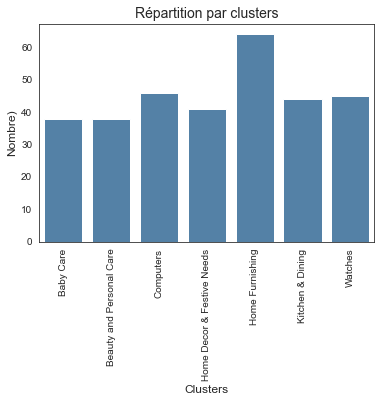

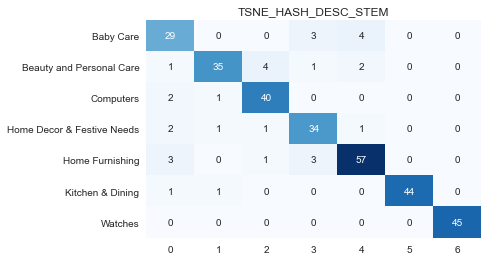

'Précision: 89.87%'

                            precision    recall  f1-score   support

                 Baby Care       0.76      0.81      0.78        36
  Beauty and Personal Care       0.92      0.81      0.86        43
                 Computers       0.87      0.93      0.90        43
Home Decor & Festive Needs       0.83      0.87      0.85        39
           Home Furnishing       0.89      0.89      0.89        64
          Kitchen & Dining       1.00      0.96      0.98        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.90       316
                 macro avg       0.90      0.90      0.90       316
              weighted avg       0.90      0.90      0.90       316


In [91]:
outils_nlp.classifier_pycaret(data_cat, vector_hashvectorizer_desc_stem,
                              titre)

In [92]:
# Sauvegarde des résultats
df_accuracy_class_we = \
    outils_nlp.sauvegarder_accuracy_we_pycaret(df_accuracy_class_we,
                                               '0.8569', '0.8987', titre)
df_accuracy_class_we[df_accuracy_class_we['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
9,TSNE_HASH_DESC_STEM,0.8569,0.8987


**produit_specification** - lemmatisée

In [93]:
# Instanciation
hashvectorizer_prod_lem = HashingVectorizer(norm=None, n_features=1259)
# Tokenisation et création du vocabulaire
hashvectorizer_prod_lem.fit(prod_lem_data)
# Hash/Vectorisation
vector_hashvectorizer_prod_lem = \
    hashvectorizer_prod_lem.transform(prod_lem_data)

In [94]:
titre = 'TSNE_HASH_PROD_LEM'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8924,0.9789,0.8925,0.9009,0.8919,0.8742,0.8757,0.0320
rf,Random Forest Classifier,0.8897,0.9800,0.8910,0.8992,0.8883,0.8711,0.8731,0.0390
catboost,CatBoost Classifier,0.8882,0.9859,0.8894,0.8958,0.8873,0.8694,0.8709,1.6650
lightgbm,Light Gradient Boosting Machine,0.8814,0.9845,0.8834,0.8873,0.8803,0.8614,0.8628,0.2270
xgboost,Extreme Gradient Boosting,0.8720,0.9836,0.8715,0.8831,0.8716,0.8503,0.8522,0.3420
knn,K Neighbors Classifier,0.8556,0.9677,0.8582,0.8629,0.8540,0.8314,0.8332,0.0080
dt,Decision Tree Classifier,0.8529,0.9137,0.8510,0.8645,0.8525,0.8280,0.8300,0.0060
gbc,Gradient Boosting Classifier,0.8447,0.9801,0.8449,0.8584,0.8432,0.8185,0.8211,0.0970
qda,Quadratic Discriminant Analysis,0.7248,0.9470,0.7237,0.7456,0.7218,0.6783,0.6829,0.0060
nb,Naive Bayes,0.7003,0.9403,0.6974,0.7127,0.6959,0.6495,0.6530,0.0060


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9304,0.9901,0.9274,0.9318,0.9306,0.9183,0.9184


Clusters,Nombre,%
Baby Care,36,11.39000
Beauty and Personal Care,43,13.61000
Computers,39,12.34000
Home Decor & Festive Needs,42,13.29000
Home Furnishing,65,20.57000
Kitchen & Dining,46,14.56000
Watches,45,14.24000


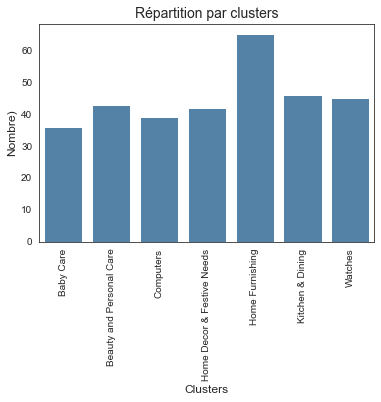

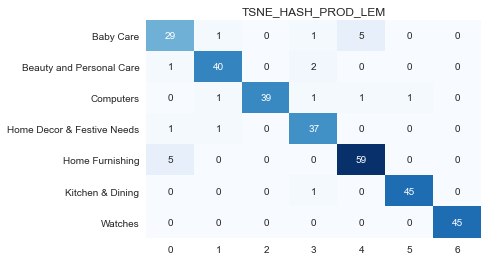

'Précision: 93.04%'

                            precision    recall  f1-score   support

                 Baby Care       0.81      0.81      0.81        36
  Beauty and Personal Care       0.93      0.93      0.93        43
                 Computers       1.00      0.91      0.95        43
Home Decor & Festive Needs       0.88      0.95      0.91        39
           Home Furnishing       0.91      0.92      0.91        64
          Kitchen & Dining       0.98      0.98      0.98        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.93       316
                 macro avg       0.93      0.93      0.93       316
              weighted avg       0.93      0.93      0.93       316


In [95]:
outils_nlp.classifier_pycaret(data_cat, vector_hashvectorizer_prod_lem,
                              titre)

In [98]:
# Sauvegarde des résultats
df_accuracy_class_we = \
    outils_nlp.sauvegarder_accuracy_we_pycaret(df_accuracy_class_we,
                                               '0.8924', '0.9304', titre)
df_accuracy_class_we[df_accuracy_class_we['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
10,TSNE_HASH_PROD_LEM,0.8924,0.9304


**produit_specification** - stemmatisée

In [99]:
# Instanciation
hashvectorizer_prod_stem = HashingVectorizer(norm=None, n_features=1195)
# Tokenisation et création du vocabulaire
hashvectorizer_prod_stem.fit(prod_stem_data)
# Hash/Vectorisation
vector_hashvectorizer_prod_stem = \
    hashvectorizer_prod_stem.transform(prod_stem_data)

In [100]:
titre = 'TSNE_HASH_PROD_STEM'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9101,0.9818,0.9104,0.9155,0.9093,0.8950,0.8961,0.0340
rf,Random Forest Classifier,0.9033,0.9833,0.9040,0.9102,0.9021,0.8871,0.8885,0.0420
catboost,CatBoost Classifier,0.8951,0.9851,0.8960,0.9034,0.8945,0.8775,0.8791,1.7020
xgboost,Extreme Gradient Boosting,0.8870,0.9845,0.8868,0.8978,0.8864,0.8679,0.8699,0.2960
dt,Decision Tree Classifier,0.8815,0.9306,0.8817,0.8940,0.8812,0.8615,0.8636,0.0070
lightgbm,Light Gradient Boosting Machine,0.8761,0.9838,0.8752,0.8832,0.8744,0.8552,0.8568,0.2160
gbc,Gradient Boosting Classifier,0.8760,0.9817,0.8762,0.8888,0.8755,0.8551,0.8574,0.1010
knn,K Neighbors Classifier,0.8651,0.9743,0.8661,0.8756,0.8633,0.8424,0.8444,0.0110
qda,Quadratic Discriminant Analysis,0.7575,0.9549,0.7552,0.7829,0.7532,0.7163,0.7213,0.0060
lr,Logistic Regression,0.7574,0.9468,0.7519,0.7805,0.7562,0.7160,0.7200,0.0210


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9304,0.9914,0.9290,0.9332,0.9307,0.9184,0.9187


Clusters,Nombre,%
Baby Care,39,12.34000
Beauty and Personal Care,42,13.29000
Computers,37,11.71000
Home Decor & Festive Needs,41,12.97000
Home Furnishing,62,19.62000
Kitchen & Dining,49,15.51000
Watches,46,14.56000


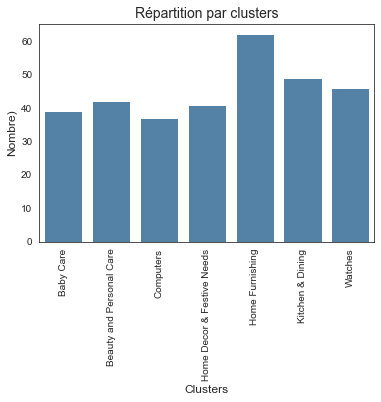

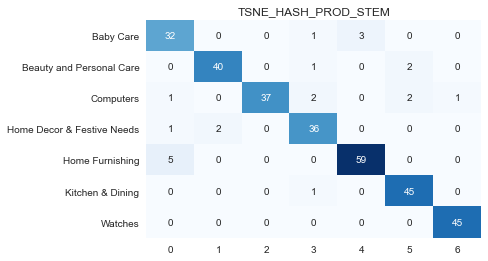

'Précision: 93.04%'

                            precision    recall  f1-score   support

                 Baby Care       0.82      0.89      0.85        36
  Beauty and Personal Care       0.95      0.93      0.94        43
                 Computers       1.00      0.86      0.92        43
Home Decor & Festive Needs       0.88      0.92      0.90        39
           Home Furnishing       0.95      0.92      0.94        64
          Kitchen & Dining       0.92      0.98      0.95        46
                   Watches       0.98      1.00      0.99        45

                  accuracy                           0.93       316
                 macro avg       0.93      0.93      0.93       316
              weighted avg       0.93      0.93      0.93       316


In [101]:
outils_nlp.classifier_pycaret(data_cat, vector_hashvectorizer_prod_stem,
                              titre)

In [102]:
# Sauvegarde des résultats
df_accuracy_class_we = \
    outils_nlp.sauvegarder_accuracy_we_pycaret(df_accuracy_class_we,
                                               '0.9101', '0.9304', titre)
df_accuracy_class_we[df_accuracy_class_we['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
11,TSNE_HASH_PROD_STEM,0.9101,0.9304


### <span style='background:PowderBlue'>4.4. Word2vec</span>

In [103]:
# Compte le nombre de coeur du processeur
cores = multiprocessing.cpu_count()

In [104]:
text_dim = 300

**description** - lemmatisée

In [106]:
# Description Lemmatisée word2vec a besoin d'une liste de liste
data_vec = data['description_clean_lemma']
data['description_lemma_token'] = \
    [word_tokenize(str(row)) for row in
     data_vec]
data_token = data['description_lemma_token'].copy()

In [107]:
# Instanciation du modèle
w2v_model_desc_lem = Word2Vec(min_count=20, window=3, size=text_dim,
                              sample=6e-5, alpha=0.03, min_alpha=0.0007,
                              negative=20, workers=cores-1)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
w2v_model_desc_lem.build_vocab(data_token,
                               progress_per=10000)
# Entraînement du modèle
w2v_model_desc_lem.train(data_token,
                         total_examples=w2v_model_desc_lem.corpus_count,
                         epochs=30, report_delay=1)
# Vectorisation
vector_w2v_desc_lem = outils_nlp.word2vec_vectorisation(data_vec,
                                                        text_dim,
                                                        w2v_model_desc_lem)

In [108]:
titre = 'TSNE_W2V_DESC_LEM'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7506,0.9324,0.7447,0.7606,0.7486,0.7086,0.7112,0.0340
rf,Random Forest Classifier,0.7478,0.9369,0.7410,0.7625,0.7467,0.7053,0.7081,0.0420
knn,K Neighbors Classifier,0.7357,0.9194,0.7275,0.7510,0.7345,0.6911,0.6942,0.0070
catboost,CatBoost Classifier,0.7343,0.9428,0.7291,0.7480,0.7342,0.6897,0.6921,1.6480
xgboost,Extreme Gradient Boosting,0.7287,0.9370,0.7230,0.7434,0.7284,0.6832,0.6859,0.3750
dt,Decision Tree Classifier,0.7246,0.8408,0.7173,0.7339,0.7212,0.6781,0.6809,0.0050
lightgbm,Light Gradient Boosting Machine,0.7193,0.9333,0.7140,0.7317,0.7181,0.6721,0.6747,0.2380
gbc,Gradient Boosting Classifier,0.7097,0.9304,0.7039,0.7389,0.7145,0.6611,0.6649,0.0880
lda,Linear Discriminant Analysis,0.6267,0.8946,0.6123,0.6284,0.6123,0.5625,0.5684,0.0050
qda,Quadratic Discriminant Analysis,0.6185,0.8934,0.6072,0.6389,0.6210,0.5540,0.5569,0.0050


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7848,0.9489,0.7921,0.7869,0.7826,0.7485,0.7497


Clusters,Nombre,%
Baby Care,41,12.97000
Beauty and Personal Care,44,13.92000
Computers,46,14.56000
Home Decor & Festive Needs,40,12.66000
Home Furnishing,49,15.51000
Kitchen & Dining,50,15.82000
Watches,46,14.56000


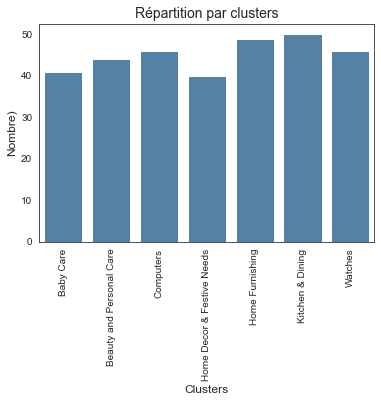

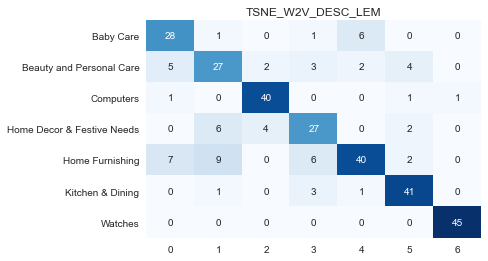

'Précision: 78.48%'

                            precision    recall  f1-score   support

                 Baby Care       0.68      0.78      0.73        36
  Beauty and Personal Care       0.61      0.63      0.62        43
                 Computers       0.87      0.93      0.90        43
Home Decor & Festive Needs       0.68      0.69      0.68        39
           Home Furnishing       0.82      0.62      0.71        64
          Kitchen & Dining       0.82      0.89      0.85        46
                   Watches       0.98      1.00      0.99        45

                  accuracy                           0.78       316
                 macro avg       0.78      0.79      0.78       316
              weighted avg       0.79      0.78      0.78       316


In [109]:
outils_nlp.classifier_pycaret(data_cat, vector_w2v_desc_lem, titre)

In [110]:
# Sauvegarde des résultats
df_accuracy_class_we = \
    outils_nlp.sauvegarder_accuracy_we_pycaret(df_accuracy_class_we,
                                               '0.7506', '0.7848', titre)
df_accuracy_class_we[df_accuracy_class_we['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
12,TSNE_W2V_DESC_LEM,0.7506,0.7848


**description** - stemmatisée

In [112]:
# Description stemmatisée word2vec a besoin d'une liste de liste
data_vec = data['description_clean_stem']
data['description_stem_token'] = \
    [word_tokenize(str(row)) for row in
     data_vec]
data_token = data['description_stem_token'].copy()

In [113]:
# Instanciation du modèle
w2v_model_desc_stem = Word2Vec(min_count=20, window=2, size=text_dim,
                               sample=6e-5, alpha=0.03, min_alpha=0.0007,
                               negative=20, workers=cores-1)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
w2v_model_desc_stem.build_vocab(data_token,
                                progress_per=10000)
# Entraînement du modèle
w2v_model_desc_stem.train(data_token,
                          total_examples=w2v_model_desc_stem.corpus_count,
                          epochs=30, report_delay=1)
# Vectorisation
vector_w2v_desc_stem = outils_nlp.word2vec_vectorisation(data_vec,
                                                         text_dim,
                                                         w2v_model_desc_stem)

In [114]:
titre = 'TSNE_W2V_DESC_STEM'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.7683,0.9480,0.7633,0.7775,0.7662,0.7294,0.7315,1.7050
rf,Random Forest Classifier,0.7615,0.9353,0.7575,0.7705,0.7598,0.7214,0.7232,0.0360
knn,K Neighbors Classifier,0.7547,0.9190,0.7485,0.7666,0.7540,0.7134,0.7158,0.0070
lightgbm,Light Gradient Boosting Machine,0.7533,0.9394,0.7462,0.7636,0.7520,0.7117,0.7136,0.2250
et,Extra Trees Classifier,0.7464,0.9291,0.7416,0.7633,0.7458,0.7038,0.7064,0.0360
xgboost,Extreme Gradient Boosting,0.7356,0.9402,0.7281,0.7504,0.7333,0.6911,0.6937,0.3960
gbc,Gradient Boosting Classifier,0.7342,0.9389,0.7287,0.7469,0.7335,0.6895,0.6916,0.0880
dt,Decision Tree Classifier,0.7220,0.8416,0.7158,0.7316,0.7193,0.6752,0.6777,0.0050
qda,Quadratic Discriminant Analysis,0.6539,0.9113,0.6503,0.6824,0.6606,0.5960,0.5983,0.0050
nb,Naive Bayes,0.6417,0.8978,0.6316,0.6659,0.6473,0.5811,0.5837,0.0050


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7690,0.9550,0.7781,0.7732,0.7662,0.7299,0.7317


Clusters,Nombre,%
Baby Care,39,12.34000
Beauty and Personal Care,33,10.44000
Computers,48,15.19000
Home Decor & Festive Needs,50,15.82000
Home Furnishing,52,16.46000
Kitchen & Dining,49,15.51000
Watches,45,14.24000


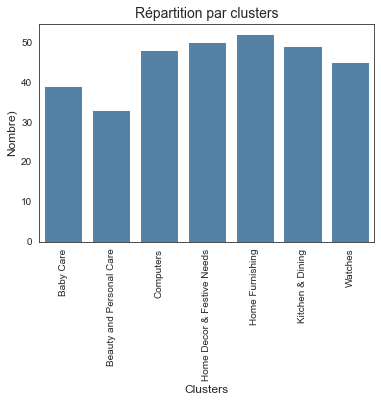

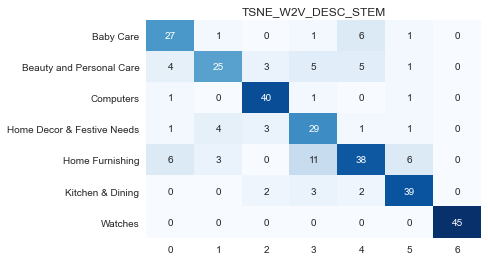

'Précision: 76.9%'

                            precision    recall  f1-score   support

                 Baby Care       0.69      0.75      0.72        36
  Beauty and Personal Care       0.76      0.58      0.66        43
                 Computers       0.83      0.93      0.88        43
Home Decor & Festive Needs       0.58      0.74      0.65        39
           Home Furnishing       0.73      0.59      0.66        64
          Kitchen & Dining       0.80      0.85      0.82        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.77       316
                 macro avg       0.77      0.78      0.77       316
              weighted avg       0.77      0.77      0.77       316


In [115]:
outils_nlp.classifier_pycaret(data_cat, vector_w2v_desc_stem, titre)

In [116]:
# Sauvegarde des résultats
df_accuracy_class_we = \
    outils_nlp.sauvegarder_accuracy_we_pycaret(df_accuracy_class_we,
                                               '0.7683', '0.7690', titre)
df_accuracy_class_we[df_accuracy_class_we['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
13,TSNE_W2V_DESC_STEM,0.7683,0.7690


**produit_specification** - lemmatisée

In [118]:
# Produit spécification Lemmatisée word2vec a besoin d'une liste de liste
data_vec = data['product_specifications_lemma']
data['product_specifications_token'] = \
    [word_tokenize(str(row)) for row in
     data_vec]
data_token = data['product_specifications_token'].copy()

In [119]:
# Instanciation du modèle
w2v_model_prod_lem = Word2Vec(min_count=20, window=3, size=text_dim,
                              sample=6e-5, alpha=0.03, min_alpha=0.0007,
                              negative=20, workers=cores-1)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
w2v_model_prod_lem.build_vocab(data_token,
                               progress_per=10000)
# Entraînement du modèle
w2v_model_prod_lem.train(data_token,
                         total_examples=w2v_model_prod_lem.corpus_count,
                         epochs=30, report_delay=1)
# Vectorisation
vector_w2v_prod_lem = outils_nlp.word2vec_vectorisation(data_vec,
                                                        text_dim,
                                                        w2v_model_prod_lem)

In [120]:
titre = 'TSNE_W2V_PROD_LEM'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.8693,0.9622,0.8708,0.8819,0.8676,0.8474,0.8501,0.0090
et,Extra Trees Classifier,0.8596,0.9669,0.8594,0.8697,0.8581,0.8360,0.8381,0.0320
catboost,CatBoost Classifier,0.8582,0.9784,0.8588,0.8684,0.8566,0.8345,0.8367,1.7320
rf,Random Forest Classifier,0.8528,0.9693,0.8537,0.8600,0.8504,0.8281,0.8301,0.0360
xgboost,Extreme Gradient Boosting,0.8515,0.9712,0.8509,0.8641,0.8513,0.8265,0.8287,0.2690
gbc,Gradient Boosting Classifier,0.8406,0.9711,0.8406,0.8524,0.8393,0.8138,0.8162,0.0910
lightgbm,Light Gradient Boosting Machine,0.8337,0.9681,0.8320,0.8433,0.8338,0.8057,0.8071,0.2030
dt,Decision Tree Classifier,0.8146,0.8918,0.8127,0.8273,0.8140,0.7834,0.7856,0.0060
lr,Logistic Regression,0.7656,0.9506,0.7625,0.7785,0.7561,0.7260,0.7309,0.0390
qda,Quadratic Discriminant Analysis,0.7655,0.9491,0.7607,0.7818,0.7556,0.7258,0.7314,0.0050


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,K Neighbors Classifier,0.8703,0.9564,0.8599,0.8683,0.8687,0.8476,0.8478


Clusters,Nombre,%
Baby Care,34,10.76000
Beauty and Personal Care,41,12.97000
Computers,45,14.24000
Home Decor & Festive Needs,36,11.39000
Home Furnishing,66,20.89000
Kitchen & Dining,49,15.51000
Watches,45,14.24000


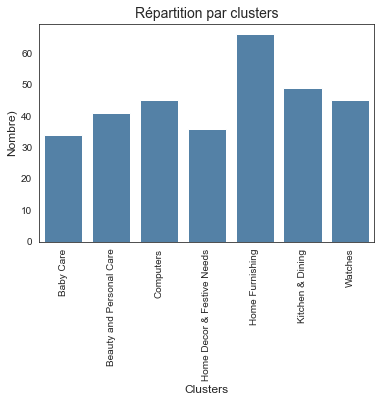

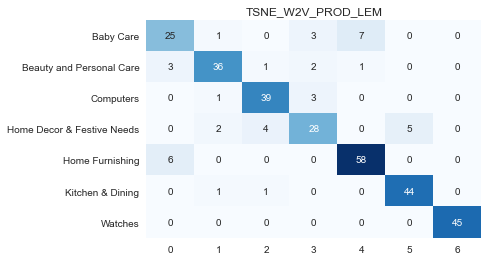

'Précision: 87.03%'

                            precision    recall  f1-score   support

                 Baby Care       0.74      0.69      0.71        36
  Beauty and Personal Care       0.88      0.84      0.86        43
                 Computers       0.87      0.91      0.89        43
Home Decor & Festive Needs       0.78      0.72      0.75        39
           Home Furnishing       0.88      0.91      0.89        64
          Kitchen & Dining       0.90      0.96      0.93        46
                   Watches       1.00      1.00      1.00        45

                  accuracy                           0.87       316
                 macro avg       0.86      0.86      0.86       316
              weighted avg       0.87      0.87      0.87       316


In [121]:
outils_nlp.classifier_pycaret(data_cat, vector_w2v_prod_lem, titre)

In [122]:
# Sauvegarde des résultats
df_accuracy_class_we = \
    outils_nlp.sauvegarder_accuracy_we_pycaret(df_accuracy_class_we,
                                               '0.8693', '0.8703', titre)
df_accuracy_class_we[df_accuracy_class_we['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
14,TSNE_W2V_PROD_LEM,0.8693,0.8703


**produit_specification** - stemmatisée

In [123]:
# Produit spécification stemmatisée word2vec a besoin d'une liste de liste
data_vec = data['product_specifications_stem']
data['product_specifications_stem_token'] = \
    [word_tokenize(str(row)) for row in
     data_vec]
data_token = data['product_specifications_stem_token'].copy()

In [124]:
# Instanciation du modèle
w2v_model_prod_stem = Word2Vec(min_count=20, window=2, size=text_dim,
                               sample=6e-5, alpha=0.03, min_alpha=0.0007,
                               negative=20, workers=cores-1)
# Construit le vocabulaire à partir d'une séquence de mots et
# initialise ainsi le modèle.
w2v_model_prod_stem.build_vocab(data_token,
                                progress_per=10000)
# Entraînement du modèle
w2v_model_prod_stem.train(data_token,
                          total_examples=w2v_model_prod_stem.corpus_count,
                          epochs=30, report_delay=1)
# Vectorisation
vector_w2v_prod_stem = outils_nlp.word2vec_vectorisation(data_vec,
                                                         text_dim,
                                                         w2v_model_prod_stem)

In [125]:
titre = 'TSNE_W2V_PROD_STEM'

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8856,0.9799,0.8862,0.8930,0.8836,0.8664,0.8682,0.0290
rf,Random Forest Classifier,0.8815,0.9782,0.8819,0.8892,0.8794,0.8617,0.8635,0.0360
lightgbm,Light Gradient Boosting Machine,0.8720,0.9798,0.8709,0.8775,0.8692,0.8505,0.8523,0.2010
catboost,CatBoost Classifier,0.8706,0.9813,0.8716,0.8762,0.8679,0.8490,0.8508,1.6230
xgboost,Extreme Gradient Boosting,0.8666,0.9770,0.8668,0.8725,0.8631,0.8442,0.8464,0.2780
knn,K Neighbors Classifier,0.8665,0.9669,0.8686,0.8752,0.8635,0.8442,0.8466,0.0070
gbc,Gradient Boosting Classifier,0.8514,0.9743,0.8506,0.8563,0.8490,0.8265,0.8280,0.0880
dt,Decision Tree Classifier,0.8488,0.9120,0.8486,0.8546,0.8465,0.8235,0.8252,0.0050
lr,Logistic Regression,0.7848,0.9537,0.7805,0.7989,0.7765,0.7483,0.7532,0.0360
lda,Linear Discriminant Analysis,0.7739,0.9473,0.7678,0.7959,0.7656,0.7354,0.7416,0.0050


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.8861,0.9766,0.8812,0.8879,0.8863,0.8663,0.8666


Clusters,Nombre,%
Baby Care,39,12.34000
Beauty and Personal Care,39,12.34000
Computers,40,12.66000
Home Decor & Festive Needs,39,12.34000
Home Furnishing,64,20.25000
Kitchen & Dining,48,15.19000
Watches,47,14.87000


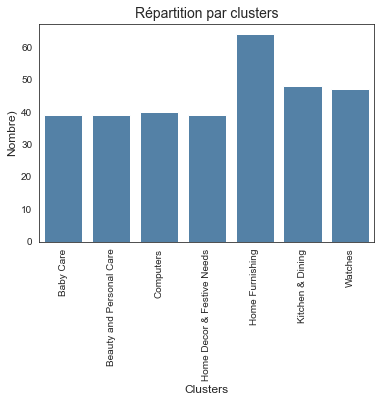

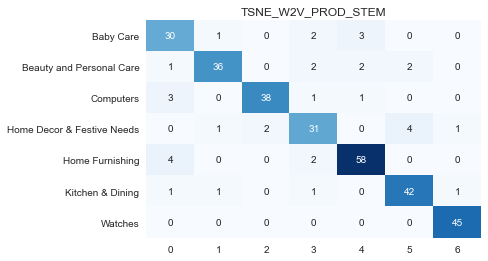

'Précision: 88.61%'

                            precision    recall  f1-score   support

                 Baby Care       0.77      0.83      0.80        36
  Beauty and Personal Care       0.92      0.84      0.88        43
                 Computers       0.95      0.88      0.92        43
Home Decor & Festive Needs       0.79      0.79      0.79        39
           Home Furnishing       0.91      0.91      0.91        64
          Kitchen & Dining       0.88      0.91      0.89        46
                   Watches       0.96      1.00      0.98        45

                  accuracy                           0.89       316
                 macro avg       0.88      0.88      0.88       316
              weighted avg       0.89      0.89      0.89       316


In [126]:
outils_nlp.classifier_pycaret(data_cat, vector_w2v_prod_stem, titre)

In [127]:
# Sauvegarde des résultats
df_accuracy_class_we = \
    outils_nlp.sauvegarder_accuracy_we_pycaret(df_accuracy_class_we,
                                               '0.8856', '0.8861', titre)
df_accuracy_class_we[df_accuracy_class_we['Type_données'] == titre]

,Type_données,Accuracy_train,Accuracy_test
15,TSNE_W2V_PROD_STEM,0.8856,0.8861


In [130]:
# Accuracy du train set
df_accuracy_class_we.sort_values(by='Accuracy_train', ascending=False)

,Type_données,Accuracy_train,Accuracy_test
7,TSNE_TFIDF_PROD_STEM,0.9264,0.9272
3,TSNE_CV_PROD_STEM,0.9196,0.9335
6,TSNE_TFIDF_PROD_LEM,0.9183,0.9430
2,TSNE_CV_PROD_LEM,0.9128,0.9430
11,TSNE_HASH_PROD_STEM,0.9101,0.9304
10,TSNE_HASH_PROD_LEM,0.8924,0.9304
5,TSNE_TFIDF_DESC_STEM,0.8923,0.9177
4,TSNE_TFIDF_DESC_LEM,0.8909,0.9114
15,TSNE_W2V_PROD_STEM,0.8856,0.8861
14,TSNE_W2V_PROD_LEM,0.8693,0.8703


In [131]:
# Accuracy du test set
df_accuracy_class_we.sort_values(by='Accuracy_test', ascending=False)

,Type_données,Accuracy_train,Accuracy_test
2,TSNE_CV_PROD_LEM,0.9128,0.9430
6,TSNE_TFIDF_PROD_LEM,0.9183,0.9430
3,TSNE_CV_PROD_STEM,0.9196,0.9335
10,TSNE_HASH_PROD_LEM,0.8924,0.9304
11,TSNE_HASH_PROD_STEM,0.9101,0.9304
7,TSNE_TFIDF_PROD_STEM,0.9264,0.9272
1,TSNE_CV_DESC_STEM,0.8556,0.9177
5,TSNE_TFIDF_DESC_STEM,0.8923,0.9177
4,TSNE_TFIDF_DESC_LEM,0.8909,0.9114
9,TSNE_HASH_DESC_STEM,0.8569,0.8987


**Bilan** :
- Les meilleurs résultats de classification sont obtenus avec la variable produit spécification lemmatisé ou stemmatisé avec CountVectorizer ou TfidfVectorizer sur le train set (> 91%) ou le test set (> 94%).